### CRF versus Vowpal Wabbit

This notebook shows a reimplementation of NER using Vowpal Wabbit in place of the CRF Suite example given in the tutorial here https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html

TLDR - Vowpal Wabbit achieves the same algorithm performance, but at a much faster speed.  

The CRF implementation took 44s to train and the Vowpal Wabbit took 6s to train. They achieved similar f-score performance on the validation set.



In [229]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [3]:
nltk.corpus.conll2002.fileids()


['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [4]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

CPU times: user 3.34 s, sys: 136 ms, total: 3.48 s
Wall time: 3.52 s


In [5]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

In [436]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
#        pass
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
#        pass
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [365]:
sent2features(train_sents[0])[0]

{'bias': 1.0,
 'word.lower()': 'melbourne',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'postag': 'NP'}

In [437]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 2.32 s, sys: 289 ms, total: 2.61 s
Wall time: 2.71 s


In [444]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 40.8 s, sys: 1.45 s, total: 42.2 s
Wall time: 44.1 s


/Users/ja/src/brock/nlp/.venv/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [196]:
labels = list(crf.classes_)
labels.remove('O')
labels


['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [286]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.7926814165010722

In [198]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-LOC      0.810     0.784     0.797      1084
       I-LOC      0.690     0.637     0.662       325
      B-MISC      0.731     0.569     0.640       339
      I-MISC      0.699     0.589     0.639       557
       B-ORG      0.807     0.832     0.820      1400
       I-ORG      0.852     0.786     0.818      1104
       B-PER      0.850     0.884     0.867       735
       I-PER      0.893     0.943     0.917       634

   micro avg      0.813     0.787     0.799      6178
   macro avg      0.791     0.753     0.770      6178
weighted avg      0.809     0.787     0.796      6178



### Find good regularization parameters
This takes an hour to run so skip down to cell 32 to just compare with Vowpal Wabbit

In [199]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/ja/src/brock/nlp/.venv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 84.2min finished


CPU times: user 1h 22min 49s, sys: 1min 3s, total: 1h 23min 53s
Wall time: 1h 24min 58s


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12e62d2d0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12e62d150>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
      

In [200]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.0840936204079157, 'c2': 0.020933936497433105}
best CV score: 0.7495351295614311
model size: 1.41M


In [226]:
rs.cv_results_['mean_test_score']

array([0.71952604, 0.74953513, 0.74684395, 0.73393991, 0.72569201,
       0.74645424, 0.73690762, 0.7478012 , 0.74677072, 0.74634089,
       0.73867617, 0.74030764, 0.74834185, 0.74150728, 0.74333355,
       0.7484378 , 0.7459279 , 0.74758248, 0.74462126, 0.74770165,
       0.74198363, 0.73396257, 0.74186112, 0.74584534, 0.74895209,
       0.74251896, 0.74856803, 0.74486346, 0.7413367 , 0.72951735,
       0.7472138 , 0.74647496, 0.74500926, 0.73824279, 0.7485859 ,
       0.72960609, 0.74018216, 0.73616049, 0.74798119, 0.74806306,
       0.72832591, 0.74525546, 0.74769604, 0.74301938, 0.73555006,
       0.74436374, 0.74868835, 0.7474537 , 0.7446519 , 0.72485471])

Dark blue => 0.7195, dark red => 0.7495


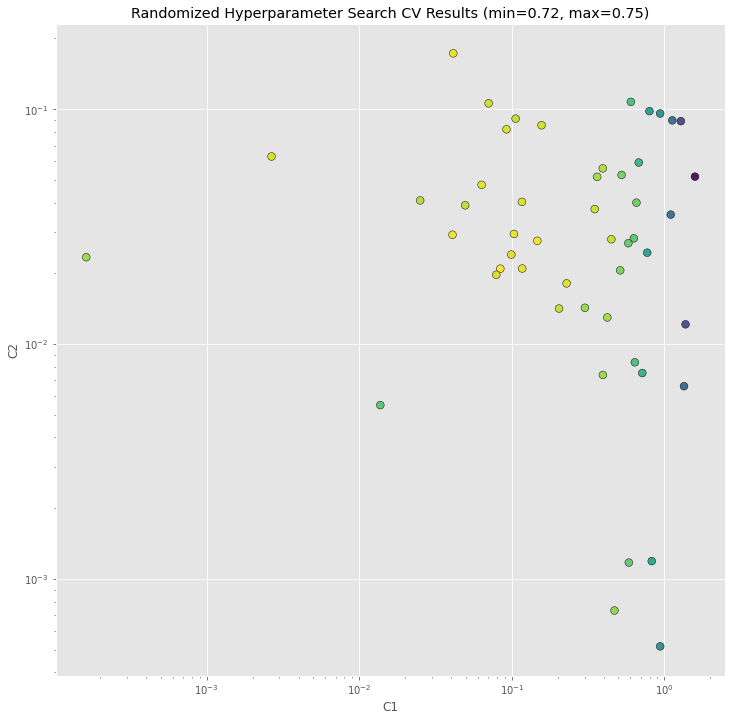

In [230]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
#_c = [s.mean_validation_score for s in rs.grid_scores_]
_c = [s for s in rs.cv_results_['mean_test_score']]


fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))


In [231]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-LOC      0.805     0.775     0.790      1084
       I-LOC      0.679     0.618     0.647       325
      B-MISC      0.721     0.563     0.632       339
      I-MISC      0.680     0.589     0.631       557
       B-ORG      0.805     0.832     0.818      1400
       I-ORG      0.853     0.785     0.818      1104
       B-PER      0.846     0.880     0.863       735
       I-PER      0.893     0.946     0.919       634

   micro avg      0.808     0.783     0.795      6178
   macro avg      0.785     0.749     0.765      6178
weighted avg      0.805     0.783     0.793      6178



In [232]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-ORG  -> I-ORG   7.692830
I-ORG  -> I-ORG   7.315137
B-MISC -> I-MISC  6.996514
B-PER  -> I-PER   6.938193
I-MISC -> I-MISC  6.862469
B-LOC  -> I-LOC   5.832921
I-PER  -> I-PER   5.087711
I-LOC  -> I-LOC   5.070981
O      -> O       4.340767
O      -> B-ORG   2.699181
O      -> B-PER   2.630990
O      -> B-LOC   1.911415
O      -> B-MISC  1.805669
B-ORG  -> O       0.491836
B-LOC  -> B-LOC   0.125653
B-ORG  -> B-LOC   0.124709
I-PER  -> B-LOC   0.034869
B-MISC -> B-ORG   -0.026072
B-MISC -> O       -0.129654
B-LOC  -> B-PER   -0.185825

Top unlikely transitions:
B-ORG  -> B-ORG   -2.811087
I-LOC  -> B-MISC  -2.832184
I-ORG  -> B-LOC   -2.838466
I-ORG  -> I-PER   -2.919752
I-MISC -> I-ORG   -3.117868
B-PER  -> B-MISC  -3.172331
I-PER  -> I-LOC   -3.296443
I-MISC -> B-LOC   -3.361274
I-ORG  -> B-MISC  -3.494127
B-PER  -> B-PER   -3.711785
I-PER  -> B-ORG   -3.713522
I-ORG  -> I-LOC   -3.842116
B-ORG  -> B-MISC  -3.899327
I-MISC -> I-LOC   -3.986468
I-PER  -> B-MI

In [233]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
12.792512 B-ORG    word.lower():efe-cantabria
11.344728 B-ORG    word.lower():psoe-progresistas
9.218917 B-ORG    word.lower():petrobras
8.747404 B-ORG    word.lower():coag-extremadura
8.682428 I-ORG    -1:word.lower():l
8.140708 I-ORG    -1:word.lower():rasd
7.592723 B-LOC    +1:word.lower():finalizaron
7.315984 I-ORG    -1:word.lower():ag
7.314277 B-ORG    +1:word.lower():plasencia
7.222892 B-ORG    -1:word.lower():sociolaboral
7.140015 B-ORG    -1:word.lower():distancia
7.115575 B-ORG    word.lower():eu-ecologista
7.059268 B-MISC   word.lower():cc2305001730
6.942482 B-ORG    word.lower():xfera
6.911962 B-PER    word.lower():orduña
6.804302 B-LOC    -1:word.lower():celebrarán
6.655427 B-ORG    word[-2:]:-e
6.637316 B-MISC   word.lower():diversia
6.610338 B-PER    word.lower():valedor
6.527150 B-LOC    -1:word.lower():cantabria
6.514201 O        word.lower():r.
6.514201 O        word[-3:]:R.
6.408508 B-MISC   word.lower():vaciamadrid
6.320985 B-PER    word.lower():reinas

In [13]:
# convert the sentences to vowpal wabbit format
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

In [14]:
train_sents[1]

[('-', 'Fg', 'O')]

### Vowpal Wabbit comparison
The below is what is necessary to compare with Vowpal Wabbit. VW is expected to be stored as a command line.
The sentences are processed to turn them into Vowpal Wabbit input format in the /tmp/ directory. Then the training and testing is run on those files.

In [32]:
# Now get all the labels
#labels_dups=[[d[2] for d in s] for s in train_sents]
labels_dups=[d[2] for s in train_sents for d in s]

print(len(labels_dups))
print(labels_dups[0:5])
#print(train_sents[2])

264715
['B-LOC', 'O', 'B-LOC', 'O', 'O']


In [53]:
#dedupe
labels = list(dict.fromkeys(labels_dups))
labels.sort(key=lambda x: x[2:] if len(x) > 2 else x)
print(labels)

['B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'O', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER']


In [108]:
numbered={b:i+1 for i, b in enumerate(labels)}

In [109]:
print(numbered)

{'B-LOC': 1, 'I-LOC': 2, 'B-MISC': 3, 'I-MISC': 4, 'O': 5, 'B-ORG': 6, 'I-ORG': 7, 'B-PER': 8, 'I-PER': 9}


In [110]:
with open("/tmp/numbered", "w") as f:
    for key, val in numbered.items():
        f.write(key +" " +str(val) + "\n")

In [111]:
!cat /tmp/numbered

B-LOC 1
I-LOC 2
B-MISC 3
I-MISC 4
O 5
B-ORG 6
I-ORG 7
B-PER 8
I-PER 9


In [254]:
with open("/tmp/converted", "w") as f:
    for s in train_sents:
        for toke in s:
            label = numbered[toke[2]]
            joined = " ".join(toke[:-1]).replace("|","").replace(":", "COLON")
            f.write(f"{label} |w {joined}\n")
        f.write("\n")

In [451]:
!head /tmp/converted

1 |w bias1.0 word.lower()melbourne word[-3COLON]rne word[-2COLON]ne word.isupper()False word.istitle()True word.isdigit()False postagNP postag[COLON2]NP BOSTrue +1COLONword.lower()( +1COLONword.istitle()False +1COLONword.isupper()False +1COLONpostagFpa +1COLONpostag[COLON2]Fp
5 |w bias1.0 word.lower()( word[-3COLON]( word[-2COLON]( word.isupper()False word.istitle()False word.isdigit()False postagFpa postag[COLON2]Fp -1COLONword.lower()melbourne -1COLONword.istitle()True -1COLONword.isupper()False -1COLONpostagNP -1COLONpostag[COLON2]NP +1COLONword.lower()australia +1COLONword.istitle()True +1COLONword.isupper()False +1COLONpostagNP +1COLONpostag[COLON2]NP
1 |w bias1.0 word.lower()australia word[-3COLON]lia word[-2COLON]ia word.isupper()False word.istitle()True word.isdigit()False postagNP postag[COLON2]NP -1COLONword.lower()( -1COLONword.istitle()False -1COLONword.isupper()False -1COLONpostagFpa -1COLONpostag[COLON2]Fp +1COLONword.lower()) +1COLONword.istitle()False +1COLONword.isuppe

In [256]:
with open("/tmp/test_converted", "w") as f:
    for s in test_sents:
        for toke in s:
            label = numbered[toke[2]]
            joined = " ".join(toke[:-1]).replace("|","").replace(":", "COLON")
            f.write(f"{label} |w {joined}\n")
        f.write("\n")

In [452]:
!head /tmp/test_converted

1 |w bias1.0 word.lower()la word[-3COLON]La word[-2COLON]La word.isupper()False word.istitle()True word.isdigit()False postagDA postag[COLON2]DA BOSTrue +1COLONword.lower()coruña +1COLONword.istitle()True +1COLONword.isupper()False +1COLONpostagNC +1COLONpostag[COLON2]NC
2 |w bias1.0 word.lower()coruña word[-3COLON]uña word[-2COLON]ña word.isupper()False word.istitle()True word.isdigit()False postagNC postag[COLON2]NC -1COLONword.lower()la -1COLONword.istitle()True -1COLONword.isupper()False -1COLONpostagDA -1COLONpostag[COLON2]DA +1COLONword.lower(), +1COLONword.istitle()False +1COLONword.isupper()False +1COLONpostagFc +1COLONpostag[COLON2]Fc
5 |w bias1.0 word.lower(), word[-3COLON], word[-2COLON], word.isupper()False word.istitle()False word.isdigit()False postagFc postag[COLON2]Fc -1COLONword.lower()coruña -1COLONword.istitle()True -1COLONword.isupper()False -1COLONpostagNC -1COLONpostag[COLON2]NC +1COLONword.lower()23 +1COLONword.istitle()False +1COLONword.isupper()False +1COLONpos

In [337]:
with open("/tmp/mycrfpredict", "r") as f:
    lines = f.readlines()
    inv_map = {v: k for k, v in numbered.items()}
    #vw_pred = [[numbered[int(t)] for t in l.split()] for l in lines]
    vw_pred = [[inv_map[int(t)] for t in l.split()] for l in lines]
    print(len(lines))


1517


In [338]:
print(vw_pred[0:2])

[['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O'], ['O']]


In [339]:
print(len(train_sents))

8323


In [340]:
#print(y_pred)
#y_pred = crf.predict(X_test)
#metrics.flat_f1_score(y_test, y_pred,
#                      average='weighted', labels=labels)
metrics.flat_f1_score(y_test, vw_pred,
                       average='weighted', labels=labels)

0.7928934492493143

In [453]:
print(lines[0:3])

['1 2 5 5 5 5 6 5 5 \n', '5 \n', '5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 8 9 9 5 5 5 5 5 1 2 5 \n']


In [143]:
X_train[0]

[{'bias': 1.0,
  'word.lower()': 'melbourne',
  'word[-3:]': 'rne',
  'word[-2:]': 'ne',
  'word.isupper()': False,
  'word.istitle()': True,
  'word.isdigit()': False,
  'postag': 'NP',
  'postag[:2]': 'NP',
  'BOS': True,
  '+1:word.lower()': '(',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'Fpa',
  '+1:postag[:2]': 'Fp'},
 {'bias': 1.0,
  'word.lower()': '(',
  'word[-3:]': '(',
  'word[-2:]': '(',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'Fpa',
  'postag[:2]': 'Fp',
  '-1:word.lower()': 'melbourne',
  '-1:word.istitle()': True,
  '-1:word.isupper()': False,
  '-1:postag': 'NP',
  '-1:postag[:2]': 'NP',
  '+1:word.lower()': 'australia',
  '+1:word.istitle()': True,
  '+1:word.isupper()': False,
  '+1:postag': 'NP',
  '+1:postag[:2]': 'NP'},
 {'bias': 1.0,
  'word.lower()': 'australia',
  'word[-3:]': 'lia',
  'word[-2:]': 'ia',
  'word.isupper()': False,
  'word.istitle()': True,
  'word.isdigit()': F

In [280]:
def replace_chars(a):
    return a.replace(" ","_").replace("|","PIPE").replace(":", "COLON")

In [408]:
def features_tostring(f):
    return " ".join([replace_chars(k) + replace_chars(str(v)) for k, v in f.items()])

In [172]:
[features_tostring(f) for f in X_train[0]]

['bias1.0 word.lower()melbourne word[-3COLON]rne word[-2COLON]ne word.isupper()False word.istitle()True word.isdigit()False postagNP postag[COLON2]NP BOSTrue +1COLONword.lower()( +1COLONword.istitle()False +1COLONword.isupper()False +1COLONpostagFpa +1COLONpostag[COLON2]Fp',
 'bias1.0 word.lower()( word[-3COLON]( word[-2COLON]( word.isupper()False word.istitle()False word.isdigit()False postagFpa postag[COLON2]Fp -1COLONword.lower()melbourne -1COLONword.istitle()True -1COLONword.isupper()False -1COLONpostagNP -1COLONpostag[COLON2]NP +1COLONword.lower()australia +1COLONword.istitle()True +1COLONword.isupper()False +1COLONpostagNP +1COLONpostag[COLON2]NP',
 'bias1.0 word.lower()australia word[-3COLON]lia word[-2COLON]ia word.isupper()False word.istitle()True word.isdigit()False postagNP postag[COLON2]NP -1COLONword.lower()( -1COLONword.istitle()False -1COLONword.isupper()False -1COLONpostagFpa -1COLONpostag[COLON2]Fp +1COLONword.lower()) +1COLONword.istitle()False +1COLONword.isupper()Fa

In [174]:
y_train[0]

['B-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']

In [438]:
%%time
with open("/tmp/converted", "w") as f:
    for s,y_vals in zip(X_train, y_train):
        for toke, y_val in zip(s,y_vals):
            label = numbered[y_val]
            #joined = " ".join(toke[:-1]).replace("|","").replace(":", "COLON")
            joined = features_tostring(toke)
            #[features_tostring(f) for f in X_train[0]]
            f.write(f"{label} |w {joined}\n")
        f.write("\n")

CPU times: user 9.45 s, sys: 267 ms, total: 9.71 s
Wall time: 10.1 s


In [439]:
with open("/tmp/test_converted", "w") as f:
    for s,y_vals in zip(X_test, y_test):
        for toke, y_val in zip(s,y_vals):
            label = numbered[y_val]
            #joined = " ".join(toke[:-1]).replace("|","").replace(":", "COLON")
            joined = features_tostring(toke)
            #[features_tostring(f) for f in X_train[0]]
            f.write(f"{label} |w {joined}\n")
        f.write("\n")

In [447]:
%%time
!rm /tmp/mycrfmodel
!vw -b 24 -k -c -d /tmp/converted --passes 6 --search_rollin learn --search_rollout none \
  --search_history_length 2  \
  --search_task sequence \
  --search 9 \
  -f /tmp/mycrfmodel 
#  --affix -2w,+2w \
#  --search_neighbor_features -2:w,-1:w,1:w \

#!vw -b 24 -k -c -d /tmp/converted --passes 6 --search_rollin learn --search_rollout none --search_history_length 2  --search_task sequence --search 9  -f /tmp/mycrfmodel 


rm: /tmp/mycrfmodel: No such file or directory
final_regressor = /tmp/mycrfmodel
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /tmp/converted.cache
Reading datafile = /tmp/converted
num sources = 1
average    since      instance            current true      current predicted   cur   cur   predic    cache  examples          
loss       last        counter           output prefix          output prefix  pass   pol     made     hits    gener  beta    
9.000000   9.000000          1  [1 5 1 5 5 5 5 5 6 ..] [1 1 1 1 1 1 1 1 1 ..]     0     0       22        0       11  0.000000
4.500000   0.000000          2  [5                   ] [5                   ]     0     0       24        0       12  0.000000
5.500000   6.500000          4  [5 5 5 8 9 5 5 5 5 ..] [5 5 5 3 5 5 5 5 5 ..]     0     0      226        0      113  0.000000
3.625000   1.750000          8  [5 5 5 5 5 5 5 5 5 ..] [5 5 5 5 5 5 5 5 5 ..]     0     0      52

In [448]:
!rm /tmp/mycrfpredict
!vw  -b 24 -t /tmp/test_converted --search_task sequence --search 9  -p /tmp/mycrfpredict -i /tmp/mycrfmodel


rm: /tmp/mycrfpredict: No such file or directory
only testing
predictions = /tmp/mycrfpredict
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /tmp/test_converted
num sources = 1
average    since      instance            current true      current predicted   cur   cur   predic    cache  examples          
loss       last        counter           output prefix          output prefix  pass   pol     made     hits    gener  beta    
0.000000   0.000000          1  [1 2 5 5 5 5 6 5 5   ] [1 2 5 5 5 5 6 5 5   ]     0     0        9        0        0  0.000000
0.000000   0.000000          2  [5                   ] [5                   ]     0     0       10        0        0  0.000000
0.500000   1.000000          4  [8 9 5 5 5 5 5 5 3 ..] [8 9 5 5 5 5 5 5 3 ..]     0     0      107        0        0  0.000000
1.000000   1.500000          8  [5 6 7 5 5 5 5 5 5 ..] [5 6 7 5 5 5 5 5 5 ..]     0     0      227        0        0  0.000000
0.93

In [449]:
with open("/tmp/mycrfpredict", "r") as f:
    lines = f.readlines()
    inv_map = {v: k for k, v in numbered.items()}
    #vw_pred = [[numbered[int(t)] for t in l.split()] for l in lines]
    vw_pred = [[inv_map[int(t)] for t in l.split()] for l in lines]
    print(len(lines))
metrics.flat_f1_score(y_test, vw_pred,
                       average='weighted', labels=labels)

1517


0.7921416040590283